# "Компьютер говорит НЕТ". Банковский скоринг

## Постановка задачи

По данным из датасета, содержащего информацию о банковских клиентах, построить модель, предсказывающую, совершит ли данный заемщик дефолт, для того, чтобы банк мог принимать решение о выдаче кредита данному заемщику. В качестве метрики использовать кривую ROC AUC.



## Описание полей

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

## Загрузка библиотек и файлов

In [1]:
# Импортируем библиотеки
import pandas as pd
from pandas import Series
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Импортируем файлы, scr - сокращенно от score
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
scr_train = pd.read_csv(DATA_DIR + 'train.csv')
scr_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [3]:
# Поиск выбросов
def outliers(col):
    IQR = scr[col].quantile(0.75) - scr[col].quantile(0.25)
    perc25 = scr[col].quantile(0.25)
    perc75 = scr[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(scr[scr[col] > r][col].count() + scr[scr[col] < l][col].count()))

## Первичный осмотр данных

In [4]:
# Проверим размерность тренировочной и тестовой выборок
print('Тренировочный датасет: ', scr_train.shape,'\nТестовый датасет: ', scr_test.shape)

Тренировочный датасет:  (73799, 19) 
Тестовый датасет:  (36349, 18)


In [5]:
# Объединим тренировочную и тестовую выборку
scr_train['sample'] = 1 # помечаем где у нас трейн
scr_test['sample'] = 0 # помечаем где у нас тест
scr_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

scr = scr_test.append(scr_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
# С помощью pandas_profiling выполним экпресс-EDA
# scr_profile = scr.profile_report()
# scr_profile.to_file("scoring_profile.html")

#### Ссылка на профайл **[scr_profile.html](./scoring_profile.html)**.

Выводы по профайлу.
(Интересно было посмотреть, как профайл автоматически сделал то, что в подготовительной части проекта мы делали вручную)

Имеем три вида данных: числовые, категориальные, бинарные.

Пропущенные значения имеются только в колонке education. Распределение данных по колонке показывает, что большинство заемщиков не имеют высшего образования.

Заемщиков женского пола заметно больше, чем заемщиков мужского пола.

Минимальный возраст заемщиков 21 год, средний 39 лет, максимальный 72 года. Чем выше возраст, тем меньше заемщиков, что логично, потому что пожилые люди реже берут кредиты.

В большинстве случаев машины у заемщика нет.

Чаще всего у заемщиков было 0 отказов, но это, очевидно, связано с тем, что далее по анализу мы видим, что дефолтных клиентов значительно меньше. Максимальное число отказов - 33, надо проверить на выбросы.

Трудно понять, что имеется в виду под "good work", у большинства значений флаг 0, будем пробовать по-другому визуализировать данные.

Скоринговый балл (показатель платежеспособности клиента) принимает как отрицательные, так и положительные значения, значения имеют нормальный вид распределения.

Надо внимательнее посмотреть на region_rating, изучить на предмет выборосов.

Гистограмма доходов смещена влево.

Распределение данных в колонке default сразу дает представление о дисбалансе выборки (не дефолтных значительно больше, чем дефолтных), следовательно будем думать, как с этим работать.

In [8]:
# Перепроверим количество пропусков по колонкам
scr.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

## Обработка пропусков

In [9]:
# Заменим пропуски в данных модой
scr['education'] = scr['education'].apply(lambda x: scr['education'].mode()[0]
                       if pd.isnull(x) == True else x)

In [10]:
# Проверим результат замены
scr.isna().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

## Опишем переменные

Так как мы не можем построить модель, не преобразовав дату в удобоваримый вид, проведем сначала обработку этой колонки.

In [11]:
# Переформатируем значения
scr.app_date = pd.to_datetime(scr.app_date)
display(scr.app_date.sample(5))

26626   2014-03-29
17291   2014-04-24
60527   2014-04-17
20112   2014-02-26
25906   2014-02-10
Name: app_date, dtype: datetime64[ns]

In [12]:
# Проанализируем период, за который нам предоставлены данные
print("Начало периода:", scr.app_date.min(),"\nКонец периода:", scr.app_date.max())

Начало периода: 2014-01-01 00:00:00 
Конец периода: 2014-04-30 00:00:00


In [13]:
# Дополнительно убедимся, что год везде один
scr.app_date.dt.year.unique()

array([2014])

Имеем данные за 4 первых месяца 2014 года, далее не будем рассматривать год как самостоятельный признак. Из того, что мы знаем из курса и предыдущего проекта, целесообразно посмотреть отдельно день, месяц, день недели и количество дней, прошедших с момента начала наблюдения.

In [14]:
# Создаем новые признаки
scr['app_day'] = scr.app_date.dt.day # день месяца
scr['app_month'] = scr.app_date.dt.month # месяц
scr['app_weekday'] = scr.app_date.dt.weekday # день недели
scr['days'] = (scr.app_date - scr.app_date.min()).dt.days # количество дней

In [15]:
# Столбец даты больше не нужен в изначальном виде, удалим его
scr.drop(['app_date'], axis = 1, inplace = True)

In [16]:
# Проверим номера колонок
scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

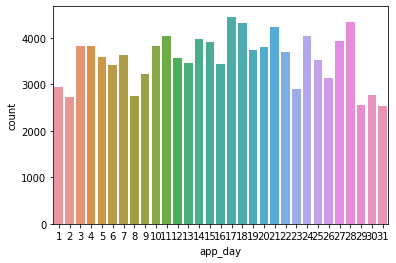

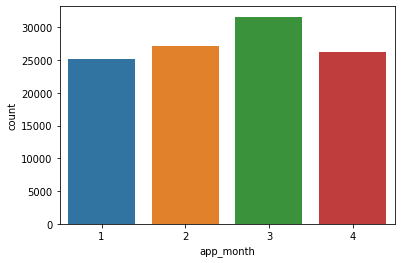

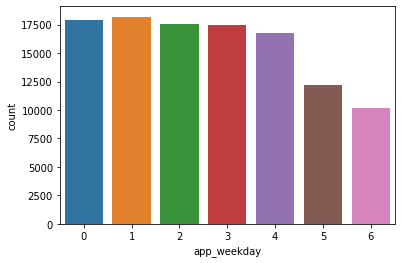

In [17]:
# Посмотрим гистограммы по новым признакам
for col in scr.iloc[:,19:22].columns:
    sns.countplot(x = scr[col], data = scr)
    plt.show()

<AxesSubplot:>

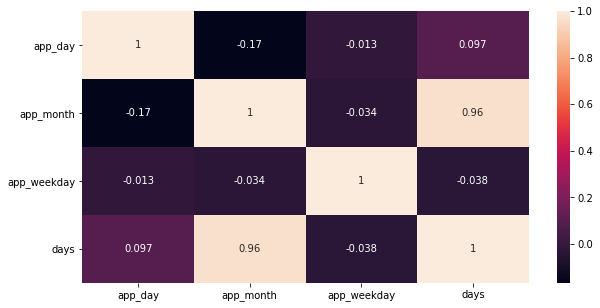

In [18]:
# Оценим новые признаки с помощью матрицы корреляции 
plt.figure(figsize=(10,5))
sns.heatmap(scr.iloc[:,19:].corr(), annot=True)

In [19]:
# Увидели, что признаки app_month и app_day имеют корреляцию, близкую к 1
# Удалим app_month как избыточный
scr.drop(['app_month'], axis = 1, inplace = True)

## Списки колонок

In [20]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = [
    'education', 
    'region_rating', 
    'home_address', 
    'work_address', 
    'sna', 
    'first_time', 
    'app_weekday'
]

# числовые переменные
num_cols = [
    'age', 
    'decline_app_cnt', 
    'score_bki', 
    'bki_request_cnt', 
    'income', 
    'app_day', 
    'days'
]

In [21]:
# Нам рекомендовано посмотреть наивную модель, поэтому сразу преобразуем бинарные переменные в 0 и 1
# Используем LabelEncoder
# Выведем на всякий случай словари значений
label_encoder = LabelEncoder()

for column in bin_cols:
    
    scr[column] = label_encoder.fit_transform(scr[column])
    print(column,dict(enumerate(label_encoder.classes_)))

sex {0: 'F', 1: 'M'}
car {0: 'N', 1: 'Y'}
car_type {0: 'N', 1: 'Y'}
good_work {0: 0, 1: 1}
foreign_passport {0: 'N', 1: 'Y'}


In [22]:
# Закодируем категории образования
ed_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
scr['education'] = scr['education'].replace(ed_dict)

In [23]:
# убедимся в преобразовании    
scr.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,sample,default,app_day,app_weekday,days
0,74835,2,1,29,1,1,0,0,-2.271884,3,...,2,50000,1,4,0,0,0,22,5,80
1,17527,0,0,39,0,0,5,0,-1.504999,2,...,2,5000,4,3,0,0,0,24,4,23
2,75683,1,1,50,1,1,0,0,-1.691339,1,...,2,30000,1,3,1,0,0,23,6,81
3,26883,0,1,56,0,0,0,0,-2.374182,1,...,2,17000,1,3,0,0,0,3,0,33
4,28862,2,0,38,0,0,0,0,-2.487502,0,...,3,120000,1,3,0,0,0,4,1,34


## Наивная модель

In [24]:
# 
scr_train_n = scr.query('sample == 1').drop(['sample'], axis = 1)
scr_test_n = scr.query('sample == 0').drop(['sample'], axis = 1)

X = scr_train_n.drop(['default'], axis = 1).values
Y = scr_train_n['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

In [25]:
model_n = LogisticRegression(max_iter = 1000)
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)

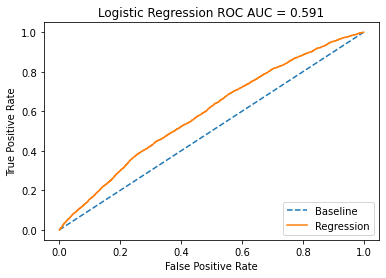

In [26]:
probs = model_n.predict_proba(X_test)
probs = probs[:,1]

# Считаем и строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [27]:
# Выведем метрики качества:
print(
    'Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)), 
    'f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)),
    'Recall: {}'.format(np.round(recall_score(y_test, y_pred), 4)),
    'MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)), sep="\n"
    )

Accuracy: 0.8744
f1_score: 0.0
Recall: 0.0
MSE: 0.1256


In [28]:
# Посчитаем матрицу ошибок
confusion_matrix(y_test, y_pred)

array([[19360,     0],
       [ 2780,     0]])

Судя по матрице ошибок, модель вообще не видит дефолтных пользователей, и таким образом, займ будет одобрен всем. Нужно улучшать модель.

## Анализ числовых переменных

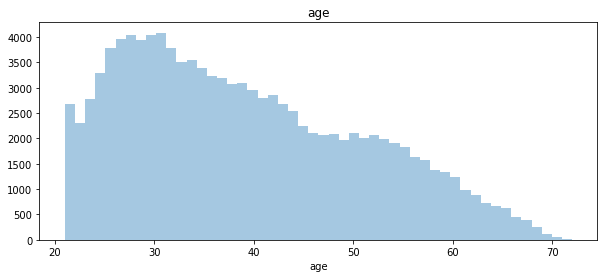

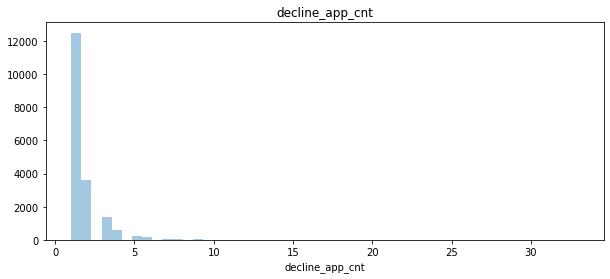

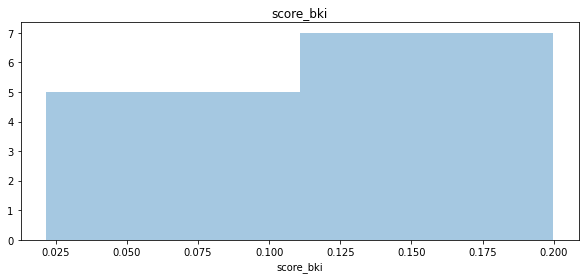

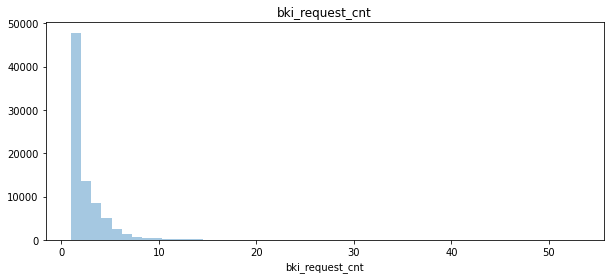

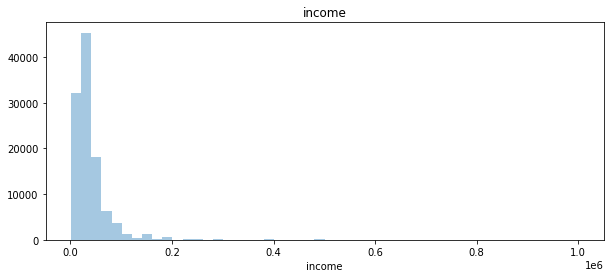

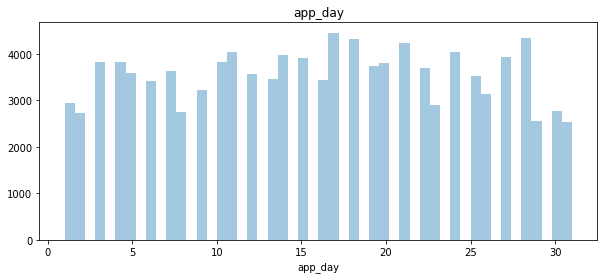

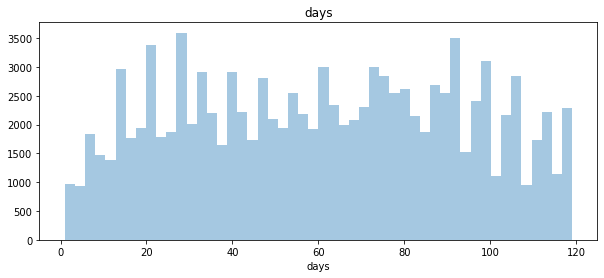

In [29]:
# Построим гистограммы распределения числовых величин
for i in num_cols:
    plt.figure(figsize=(10, 4))
    sns.distplot(scr[i][scr[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Видим по графикам, что некоторые распределения смещены влево. 

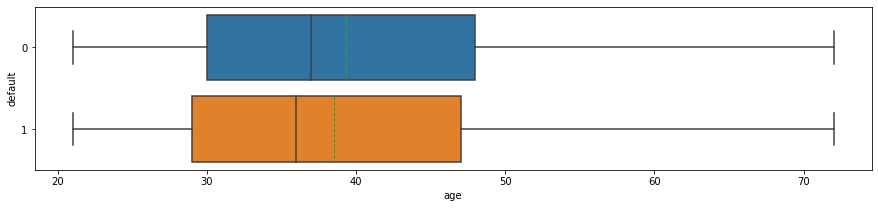

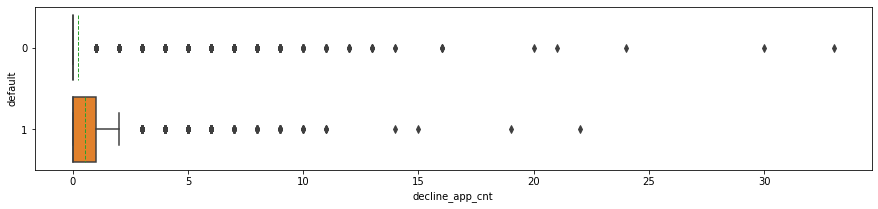

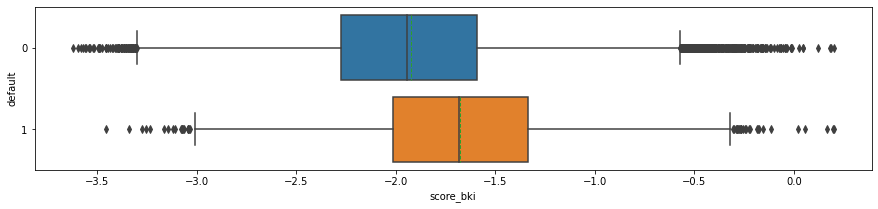

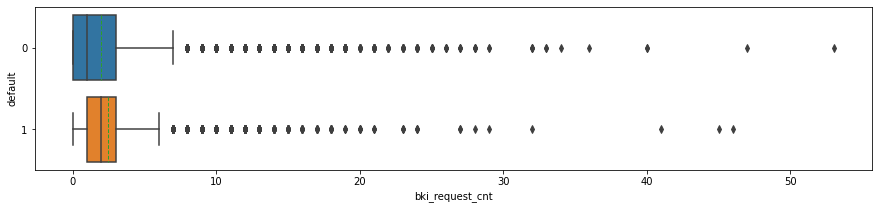

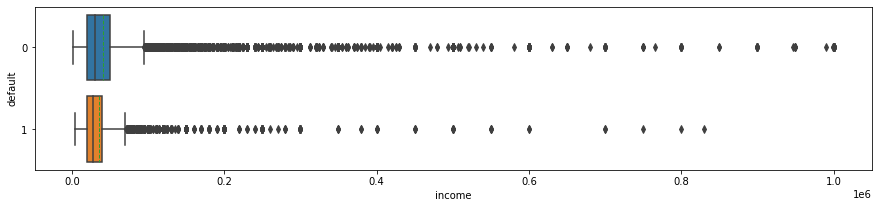

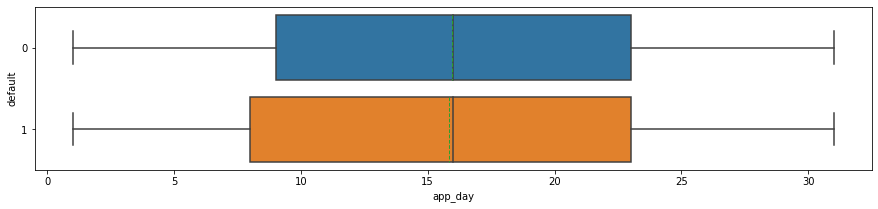

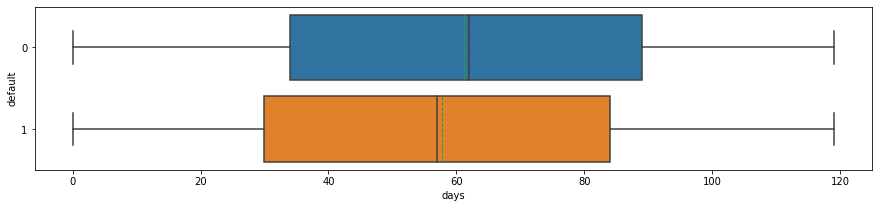

In [30]:
# Посмотрим на боксплоты и выбросы
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = scr['default'], x = scr[col],
            showmeans=True, meanline=True, orient = 'h')

Мы видим, что клиенты с дефолтом в среднем более молодые, имели больше запросов в БКИ и больше отказов по заявкам. День подачи заявки не влияет на дефолтность, можно его убрать. Нужно поработать с колонками, в которых есть выбросы.

In [31]:
# Удаляем app_day
scr.drop(['app_day'], axis=1, inplace=True)
num_cols.remove('app_day')

In [32]:
outliers('decline_app_cnt')
outliers('income')
outliers('bki_request_cnt')
outliers('score_bki')

Для decline_app_cnt IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Всего 18677 выбросов
Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов


Коллеги подсказывают, что decline_app_cnt и bki_request_cnt можно перевести в категориальные признаки по принципу 1-2-3-много.

In [33]:
# Посмотрим наиболее частные значения
scr.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

In [34]:
# Заменим значения
scr.decline_app_cnt = scr.decline_app_cnt.apply(lambda x: (x if x < 4 else 4))

# Удалим колонку из списка числовых и добавим в список категориальных
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [35]:
scr.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

In [36]:
# Заменим значения
scr.bki_request_cnt = scr.decline_app_cnt.apply(lambda x: (x if x < 7 else 7))

# Удалим колонку из списка числовых и добавим в список категориальных
num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

<AxesSubplot:>

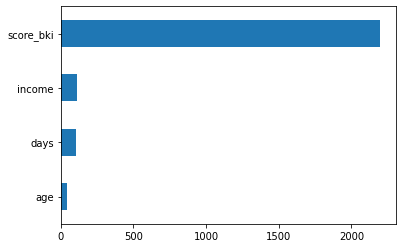

In [37]:
# Проведем оценку значимости признаков с помощью функции f_classif
# Визуализируем результат
imp_num = pd.Series(f_classif(scr[num_cols], scr['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

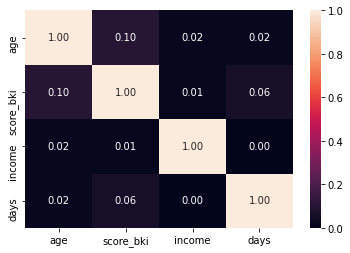

In [38]:
# Оценим корреляцию по Пирсону
sns.heatmap(scr[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Признаки коррелируют слабо, оставляем для модели все. Вернемся к колонкам со смещенными распределениями и приведем их к более нормальному виду с помощью логарифмирования.

In [39]:
# Логарифмируем числовые колонки
scr['income'] = scr['income'].apply(lambda x: np.log(x + 1))
# scr['score_bki'] = scr['score_bki'].apply(lambda x: np.log(x + 1))
# не логарифмируем

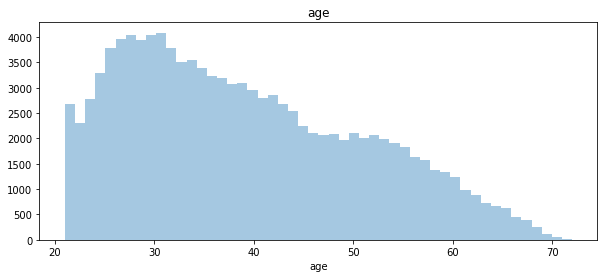

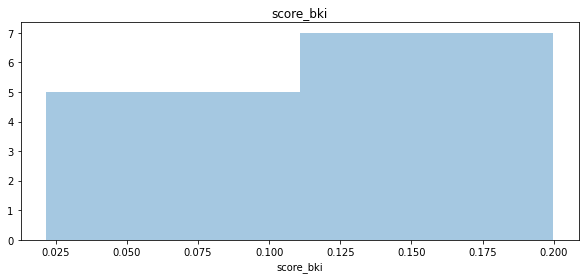

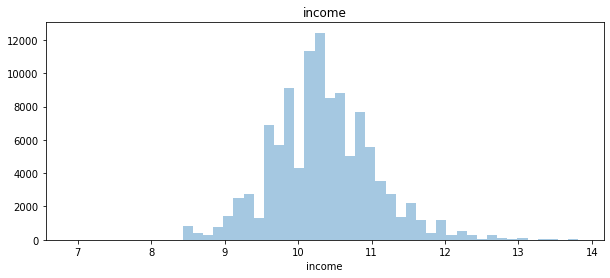

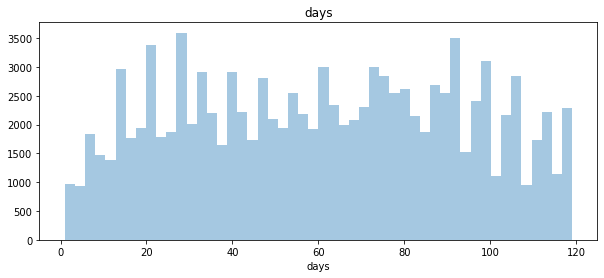

In [40]:
# Построим гистограммы логарифмированных данных
for i in num_cols:
    plt.figure(figsize=(10, 4))
    sns.distplot(scr[i][scr[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

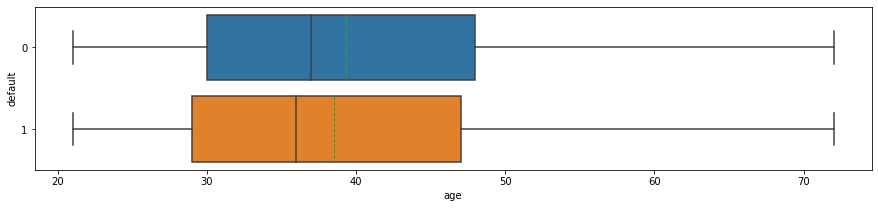

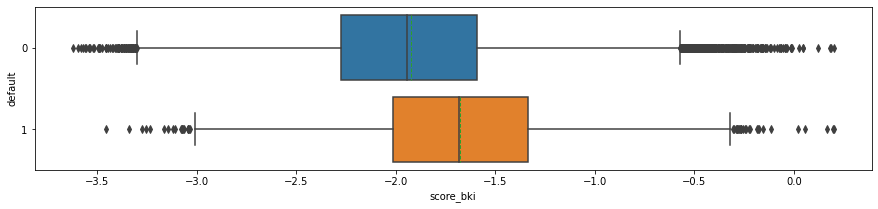

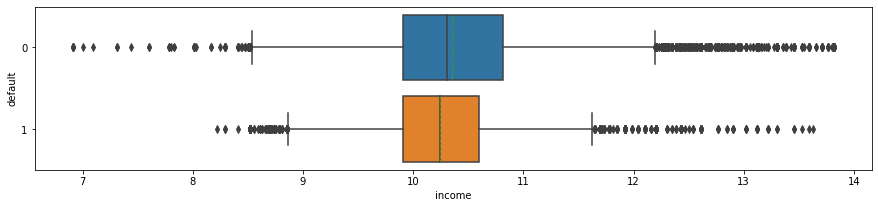

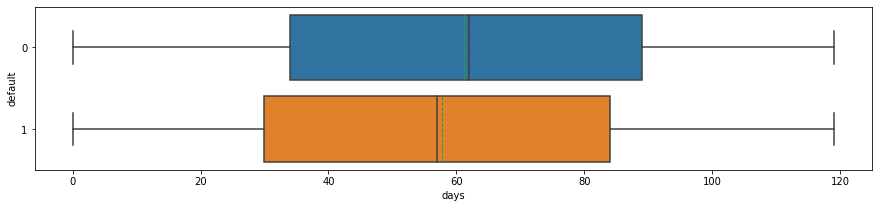

In [41]:
# Посмотрим на боксплоты и выбросы после преобразований
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = scr['default'], x = scr[col],
            showmeans=True, meanline=True, orient = 'h')

In [42]:
outliers('income')
# outliers('score_bki')

Для income IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов


Итак, дополнительно скажем, что средний доход у дефолтных клиентов, также меньше их средний возраст. На данном этапе работы принято решение ничего не делать с выбросами. Распределение дохода вполне правдоподобно, а для решения по выбросам в score_bki нужно углубленное знание темы. 

## Анализ категориальных признаков

<AxesSubplot:>

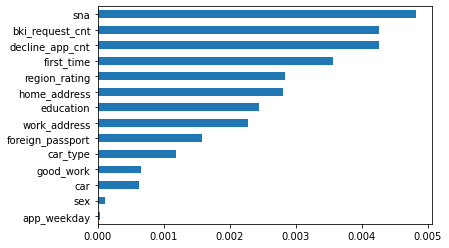

In [43]:
# Оценим значимость категориальных переменных
imp_cat = Series(mutual_info_classif(scr[bin_cols + cat_cols], scr['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Судя по гистограмме, самый важный признак - это связь заемщика с другими клиентами банка. Количество запросов в БКИ и количество отказов имеют примерно одинковую важность. Оставим все показатели.

<AxesSubplot:>

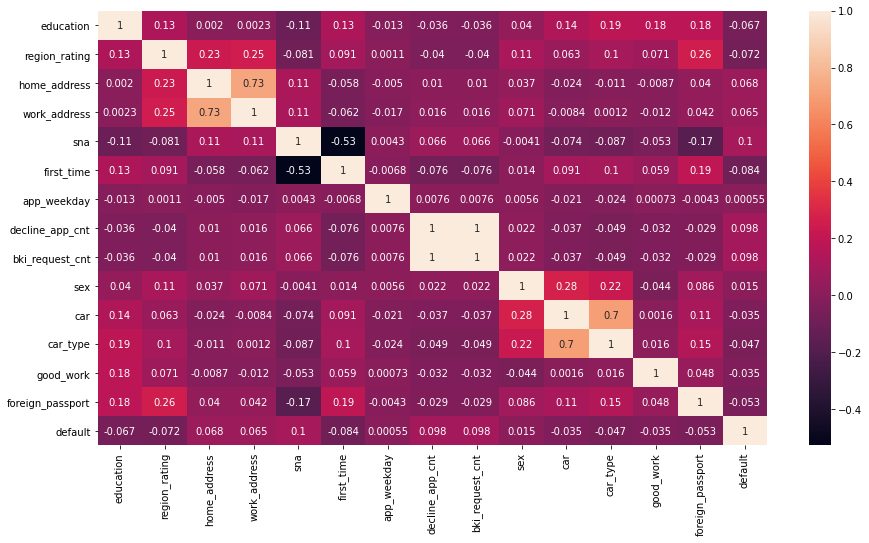

In [44]:
# Построим матрицу корреляций для категориальных признаков:
plt.figure(figsize=(15,8))
sns.heatmap(scr[cat_cols + bin_cols + ['default']].corr(), annot=True)

Видим, что рабочий и домашний адрес имеют довольно высокую корреляцию, так же как и наличие и тип машины. Но она не настолько высокая, чтобы от нее избавляться.

## Feature engineering

In [45]:
# Применим One-Hot encoding для категориальных переменных
scr = pd.get_dummies(scr, columns = cat_cols)

scr.head()

,client_id,sex,age,car,car_type,good_work,score_bki,income,foreign_passport,sample,...,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,bki_request_cnt_0,bki_request_cnt_1,bki_request_cnt_2,bki_request_cnt_3,bki_request_cnt_4
0,74835,1,29,1,1,0,-2.271884,10.819798,0,0,...,1,0,0,0,0,1,0,0,0,0
1,17527,0,39,0,0,0,-1.504999,8.517393,0,0,...,0,0,0,0,1,0,0,0,0,1
2,75683,1,50,1,1,0,-1.691339,10.308986,1,0,...,1,0,0,0,0,1,0,0,0,0
3,26883,1,56,0,0,0,-2.374182,9.741027,0,0,...,1,0,0,0,0,1,0,0,0,0
4,28862,0,38,0,0,0,-2.487502,11.695255,0,0,...,1,0,0,0,0,1,0,0,0,0
